<a href="https://colab.research.google.com/github/beyondbond/eSTAR/blob/master/stock_analysis_with_machine_learning_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# stock_analysis_with_machine_learning_rf
Machine Learning KNN/RandomForest in Finacial Application
stock return forecasts with technical indicatiors via ML

## 1. Request and Clean Data 
#### Using U.S. EST time as local timestamp to pull SPY minute data
Suggested tickers to use from DOW30:  MMM, AXP, AAPL, BA, CAT, CVX, CSCO, KO, DWDP, XOM, GS, HD, IBM, INTC, JNJ, JPM, MCD, MRK, MSFT, NKE, PFE, PG, TRV, UNH, UTX, VZ, V, WMT, WBA, DIS


Run analysis @ Thu Feb  7 14:37:27 2019


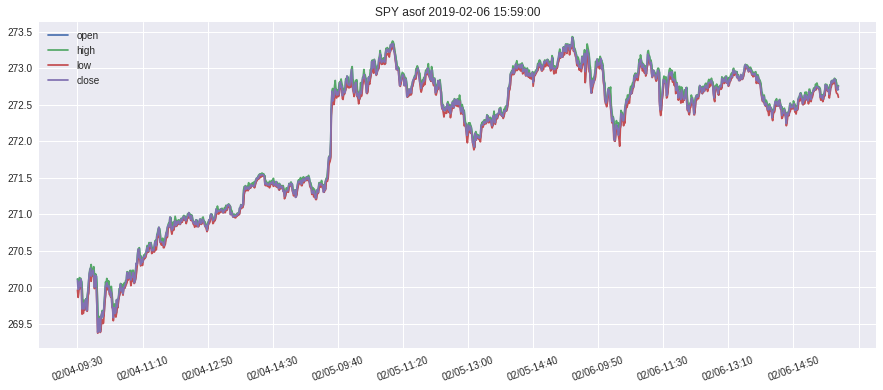

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import requests
import os, time

# Set local time zone to NYC
os.environ['TZ']='America/New_York'
time.tzset()
t=time.localtime() # string
print('Run analysis @ {}'.format(time.ctime()))

ticker='SPY'
#urx="https://query1.finance.yahoo.com/v8/finance/chart/{}?region=US&lang=en-US&includePrePost=false&interval={}&range={}"
#url = urx.format(ticker,'1m','5d')
urx="https://query1.finance.yahoo.com/v8/finance/chart/{}?region=US&lang=en-US&includePrePost=false&interval={}&period1={}&period2={}"
period1=(datetime.datetime.today().date()-datetime.timedelta(5)).strftime('%s')
period2=datetime.datetime.today().date().strftime('%s')
url = urx.format(ticker,'1m',period1,period2)

jTmp = pd.read_json(url)['chart']['result'][0]
pbdatetime = [ datetime.datetime.fromtimestamp(int(x)) for x in jTmp['timestamp'] ]
df=pd.DataFrame(jTmp['indicators']['quote'][0])
df.loc[:,'ticker']=ticker
#df.set_index(pd.DatetimeIndex(pbdatetime),inplace=True)
df.dropna(inplace=True)
df = df[['open','high','low','close']]
title = '{} asof {}'.format(ticker,pbdatetime[-1])
fig, ax=plt.subplots(figsize=(15,6))
df.plot(ax=ax,title=title)

# set xticks
plt.locator_params(axis='x', nbins=20)  # x-axis
vn=range(len(pbdatetime))
xtcks = [pbdatetime[int(j)].strftime('%m/%d-%H:%M') if j in vn else None for j in ax.get_xticks()]
ax.set_xticklabels(xtcks)

plt.xticks(rotation='20',fontsize=10)
plt.show()


## 2. Build Features and Labeling
### Use RSI, MACD, MA(10) and Bollinger Band and ADX as stock singals
### Use up/down/no_change for y labeling
#### Note, install ta for technical indicators
#### ! pip install ta

In [0]:
! pip install ta
import ta
# RSI
df['rsi'] = ta.momentum.rsi(df['close'],n=14)
df['rsi_singal'] = [ 1 if x>=70 else -1 if x<=30 else 0 for x in df['rsi'] ]
df['rrt'] = df['close'].pct_change()

# MACD setup
df['macd'] = ta.trend.macd(df['close'], n_fast=12, n_slow=26, fillna=False)
df['macd_xover']=df['macd'] - df['macd'].ewm(span=9).mean()
df['macd_xover_signal'] = [ 1 if x>0 else -1 if x<0 else 0 for x in df['macd_xover'] ]
df['macd_signal'] = (np.sign(df['macd_xover_signal'] - df['macd_xover_signal'].shift(1)))

# ADX setup
df['adx'] = ta.trend.adx(df['high'], df['low'], df['close'], n=14).values

# Bollinger Band
df['bband_up'] = ta.volatility.bollinger_hband(df['rrt'], n=20, ndev=0.5)
df['bband_dn'] = ta.volatility.bollinger_lband(df['rrt'], n=20, ndev=0.5)

# MA(20) setup
df['ma'] = ta.volatility.bollinger_mavg(df['rrt'], n=20)
df['ma'] = df['ma'].shift(1)
df = df.replace([np.inf, -np.inf], np.nan)

# y labeling
df['Direction'] = [ 1 if x>=0 else -1 for x in df['rrt'] ]
df.dropna(inplace=True)
print(df.tail())

            open        high         low       close        rsi  rsi_singal  \
1165  272.839996  272.839996  272.700012  272.779999  50.185094           0   
1166  272.780212  272.799988  272.660004  272.719788  39.042339           0   
1167  272.709991  272.730011  272.649994  272.709991  37.480110           0   
1168  272.700012  272.732513  272.640015  272.709991  37.480110           0   
1169  272.709991  272.760010  272.600006  272.750000  48.651981           0   

           rrt      macd  macd_xover  macd_xover_signal  macd_signal  \
1165 -0.000183  0.043117    0.004519                  1          0.0   
1166 -0.000221  0.034603   -0.003195                 -1         -1.0   
1167 -0.000036  0.026758   -0.008833                 -1          0.0   
1168  0.000000  0.020306   -0.012228                 -1          0.0   
1169  0.000147  0.018211   -0.011458                 -1          0.0   

            adx  bband_up  bband_dn        ma  Direction  
1165  19.306888  0.000119 -0.0000

/usr/local/lib/python3.6/dist-packages/ta/trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])


##  3. Dataset Manipulation

In [0]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
#from sklearn.linear_model import LogisticRegression
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
#from sklearn.svm import LinearSVC, SVC
#from sklearn.neural_network import MLPClassifier

### Split Data into Train and Test Sets

In [0]:
XData = df[['adx','rsi','macd','ma']].values
yData = df['Direction'].values
X_train_raw, X_test_raw, y_train, y_test = train_test_split(XData,yData,test_size=0.2,shuffle=False)


## 4. Data Selection and Normalization


In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit(X_train_raw).transform(X_train_raw)
X_test = scaler.fit(X_test_raw).transform(X_test_raw)


## 5. Fitting and Predicting




In [0]:
models = [
   ("KNN", KNeighborsClassifier(n_neighbors = 10)
   ),
   ("RF", RandomForestClassifier(
       n_estimators=1000, criterion='gini', max_depth=None,
       min_samples_split=10, min_samples_leaf=2, max_features='auto',
       bootstrap=True, oob_score=False, n_jobs=1,
       random_state=None, verbose=1)
    )]

for m in models:
    (name, clf) = m
    # Train each of the models on the training set
    clf.fit(X_train, y_train)

    # Make an array of predictions on the test set
    fitted = clf.predict(X_train)
    pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    acScore = accuracy_score(y_test,pred)
    confMtx = confusion_matrix(y_test, pred)

    # Output the hit-rate and the confusion matrix for each model
    print("Method: {}, Score:{:.5f}, accuracyScore:{:.5f}".format(name, score,acScore))
    print("confusion Matrix:\n{}".format(confMtx) )
    # Output the hit-rate and the confusion matrix for each model
    print("Method: {}, Score:{:.5f}, accuracyScore:{:.5f}".format(name, score,acScore))
    print("confusion Matrix:\n{}".format(confMtx) )    
    


Method: KNN, Score:0.70742, accuracyScore:0.70742
confusion Matrix:
[[77 32]
 [35 85]]
Method: KNN, Score:0.70742, accuracyScore:0.70742
confusion Matrix:
[[77 32]
 [35 85]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Method: RF, Score:0.69869, accuracyScore:0.69869
confusion Matrix:
[[84 25]
 [44 76]]
Method: RF, Score:0.69869, accuracyScore:0.69869
confusion Matrix:
[[84 25]
 [44 76]]


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


## 6. Fitting and predition Analysis

(916,) (916,) (916,)


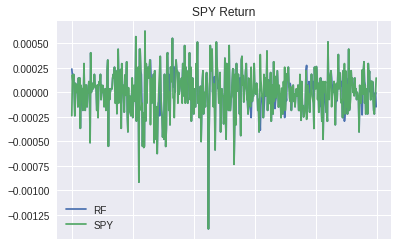

In [0]:
nobs=X_test.shape[0]
nobt=y_train.shape[0]
act_rrt = df['rrt']
train_rrt = df['rrt'].iloc[:nobt].values
print(fitted.shape,y_train.shape,train_rrt.shape)
fitted_rrt = fitted*y_train*train_rrt
test_rrt = df['rrt'].iloc[-nobs:].values
pred_rrt = pred*y_test*test_rrt
fit_rrt = np.append(fitted_rrt,pred_rrt)
dg = pd.DataFrame(np.transpose([fit_rrt,act_rrt]),columns=[name,ticker])
title='{} Return'.format(ticker)
tidx=[x.strftime('%m/%d-%H:%M') for x in pbdatetime[:nobt+nobs]]
dg.index = tidx
dg.iloc[-500:].plot(title=title)
plt.show()

## 7. Profit and Loss Analysis


2019-02-07 13:30:54.308209


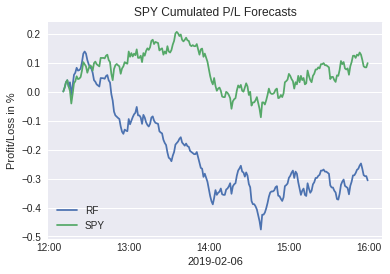

In [0]:
nobs=X_test.shape[0]
test_rrt = df['rrt'].iloc[-nobs:].values
pred_rrt = pred*y_test*test_rrt

dh = pd.DataFrame(np.transpose([pred_rrt,test_rrt]),columns=[name,ticker])
dh = dh.cumsum().apply(lambda x:np.exp(x)*100-100)
dh.set_index(pd.DatetimeIndex(pbdatetime[-nobs:]),inplace=True)
title = '{} Cumulated P/L Forecasts'.format(ticker)
dh.plot(title=title)
plt.legend()
plt.xlabel(pbdatetime[-1].strftime('%Y-%m-%d'))
plt.ylabel('Profit/Loss in %')
print(datetime.datetime.now())
plt.show()